In [2]:
%matplotlib inline 
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [35]:
device =  "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [36]:
def load_image(img_path, max_size=400, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    # Here we are to make sure that our image size dimensions do not exceed the max we set
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    # to make sure if shape argument is passed then shape of style image is made similar to content image.
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
                        transforms.Resize(size), # make the smaller edge to the max (400), larger would be > 400 but the ratio would be same.
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])

    image = in_transform(image).unsqueeze(0)
    
    return image


In [37]:
# importing the images to use. 
content = load_image('nightmare.jpg').to(device) # image to add style to.
style = load_image('starry.jpg').to(device) # image to add style from.

In [38]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze() # to make compatible for plotting 
    image = image.transpose(1,2,0) # swapping the channels
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) # scaling the images
    image = image.clip(0, 1) # clipping the pixel values

    return image

(-0.5, 511.5, 399.5, -0.5)

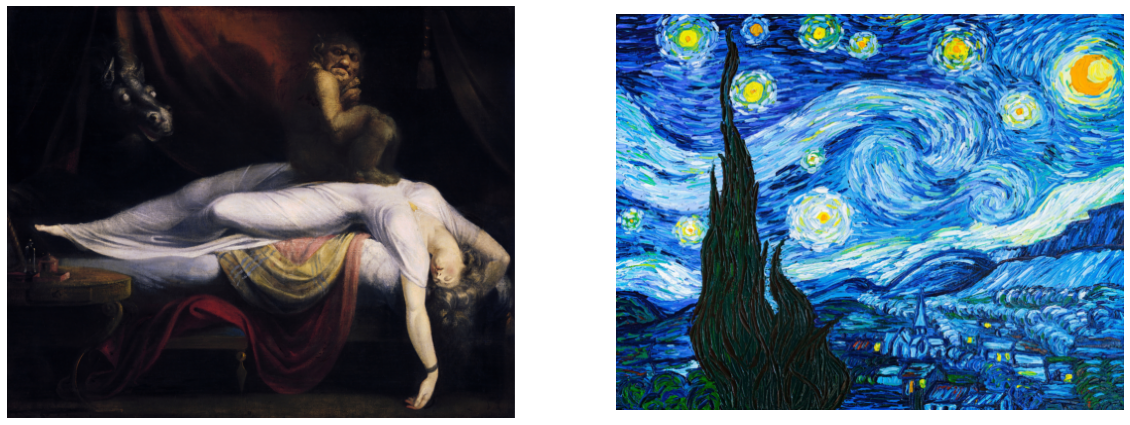

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [40]:
def get_features(image, model):
    
    # choosing the layers of vgg net to extract the features from. As mentioned in the paper.
    # getting the first conv layers from each block
    # conv<block_number>_<layer_number>
    layers = {'0': 'conv1_1', # style extraction
              '5': 'conv2_1', # style extraction
              '10': 'conv3_1', # style extraction
              '19': 'conv4_1', # style extraction
              '21': 'conv4_2',  # content extraction
              '28': 'conv5_1'} # style extraction
        
    # matching the content features with target image features will allow for optimal content creating in 
    #  the target image. We are using more style extraction layers because it is more complex than content.
    
    features = {}

    # we will iterate over the layers of model and pass the image through it.
    # if the layer is one of out defined, then we add it to our features dictionary.
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [41]:
# extracting the features from the defined function
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

$$Gram = V^T * V$$

In [42]:
# by applying gram matrix to extracted features we eliminate lot of content but the style features are retained
# helps to create texture information
def gram_matrix(tensor):
    _, d, h, w = tensor.size() # getting the dimensions
    tensor = tensor.view(d, h * w) # new 2d tensor 
    gram = torch.mm(tensor, tensor.t()) # applying the formula
    return gram

In [43]:
# getting the gram matrix for all the style layers
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [44]:
# layers closer to the beginning are usually more effective recreating style features.
# so we can provide higher weights to the early layers.
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# the lower the ratio the more style would be transferred in the target image
content_weight = 1  # alpha
style_weight = 1e6  # beta , this makes the ration 1e-6

In [45]:
target = content.clone().requires_grad_(True).to(device)

In [46]:
show_every = 300 # this will give us the progress every defined iterations.
optimizer = optim.Adam([target], lr=0.003) # we have to optimizer the target image
steps = 10000 # for how many steps we want to run the optimizations

height, width, channels = im_convert(target).shape
# we create an array that stores the target image throughout the process
image_array = np.empty(shape=(300, height, width, channels)) 
capture_frame = steps/300
counter = 0

Total loss:  19134166.0
Iteration:  300


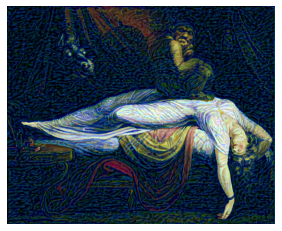

Total loss:  4512345.5
Iteration:  600


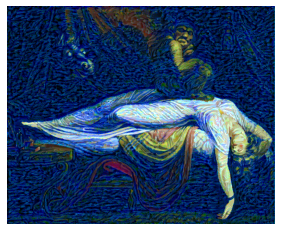

Total loss:  2832809.75
Iteration:  900


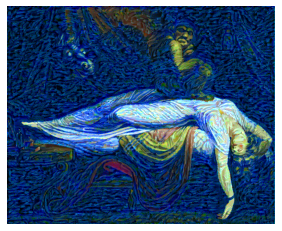

Total loss:  1886810.5
Iteration:  1200


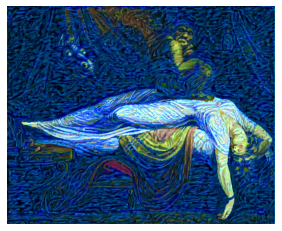

Total loss:  1288298.5
Iteration:  1500


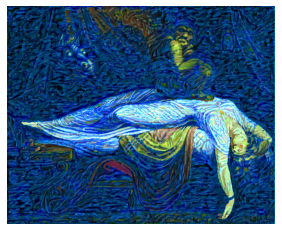

Total loss:  904246.6875
Iteration:  1800


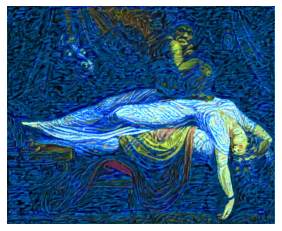

Total loss:  652297.0625
Iteration:  2100


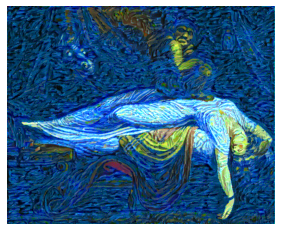

Total loss:  482177.8125
Iteration:  2400


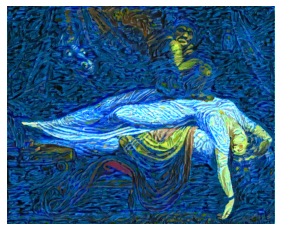

Total loss:  363842.53125
Iteration:  2700


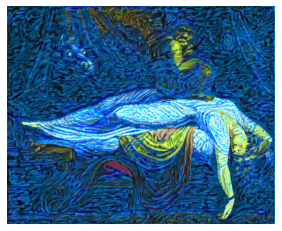

Total loss:  279320.625
Iteration:  3000


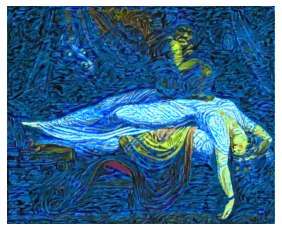

Total loss:  217717.421875
Iteration:  3300


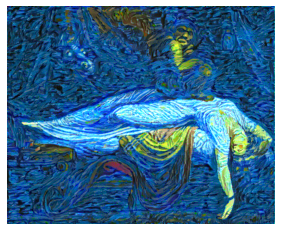

Total loss:  172061.21875
Iteration:  3600


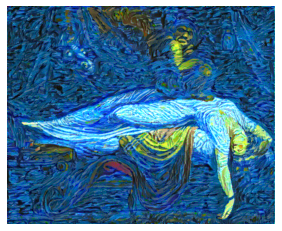

Total loss:  137791.515625
Iteration:  3900


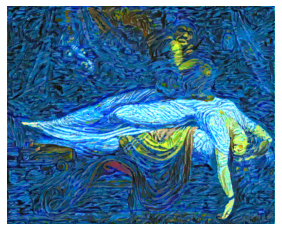

Total loss:  111842.90625
Iteration:  4200


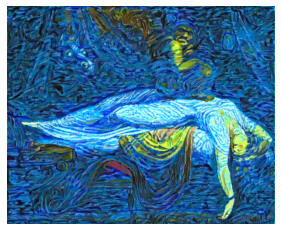

Total loss:  92061.328125
Iteration:  4500


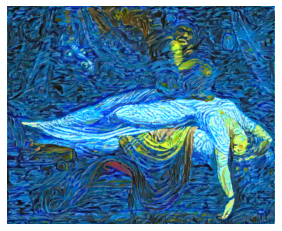

Total loss:  76920.5546875
Iteration:  4800


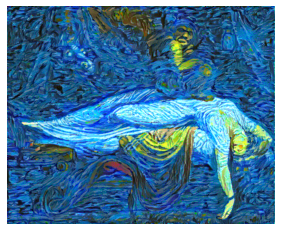

Total loss:  65301.75
Iteration:  5100


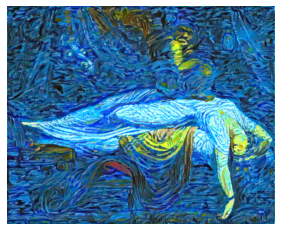

Total loss:  56323.91796875
Iteration:  5400


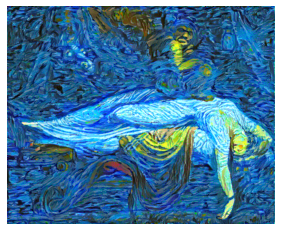

Total loss:  49312.83984375
Iteration:  5700


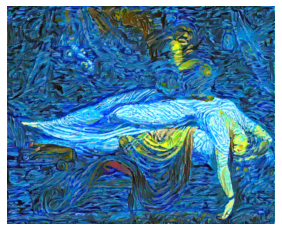

Total loss:  43762.96875
Iteration:  6000


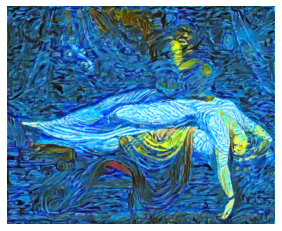

Total loss:  39295.20703125
Iteration:  6300


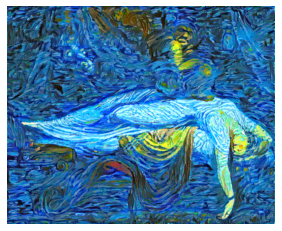

Total loss:  35647.84765625
Iteration:  6600


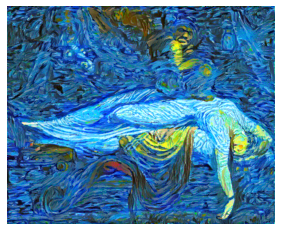

Total loss:  32683.376953125
Iteration:  6900


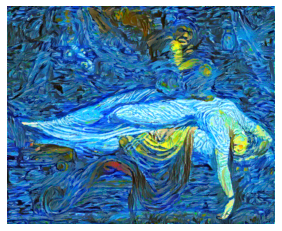

Total loss:  30312.6328125
Iteration:  7200


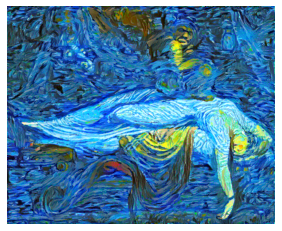

Total loss:  28099.142578125
Iteration:  7500


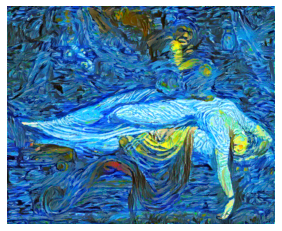

Total loss:  26362.85546875
Iteration:  7800


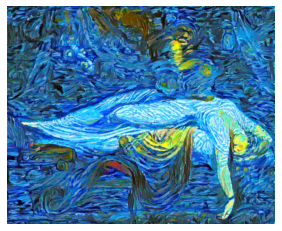

Total loss:  25013.0546875
Iteration:  8100


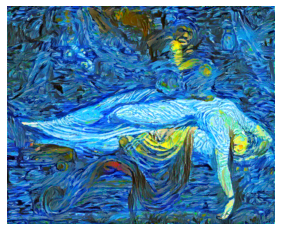

Total loss:  23867.0703125
Iteration:  8400


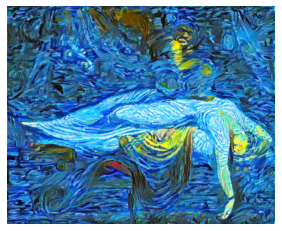

Total loss:  22750.59375
Iteration:  8700


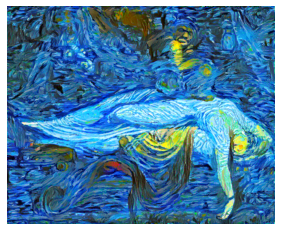

Total loss:  21841.203125
Iteration:  9000


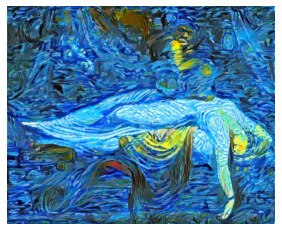

Total loss:  21341.8671875
Iteration:  9300


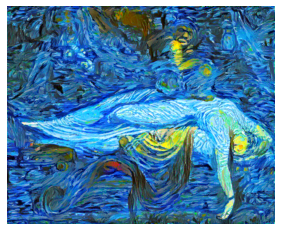

Total loss:  20296.423828125
Iteration:  9600


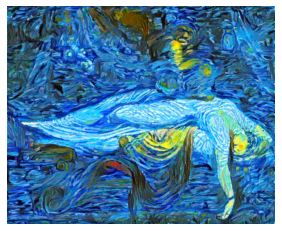

Total loss:  19885.97265625
Iteration:  9900


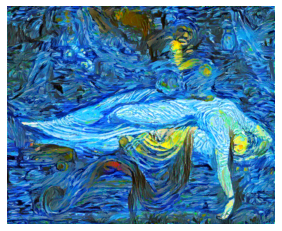

In [47]:
for ii in range(1, steps+1):
    # collection of features for out current target image
    target_features = get_features(target, vgg)
    # using mse to get the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    
    # to go through each layer of style dictionary
    for layer in style_weights:
        # collecting the target features
        target_feature = target_features[layer]
        # obtaining the gram matrix of target features
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        # getting the layer style loss
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        # getting the unit style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # the combined weighted content and style loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # to check the progress, printing the metrics and image.
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    
    # collecting the frames to form a video of the process
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

(-0.5, 492.5, 399.5, -0.5)

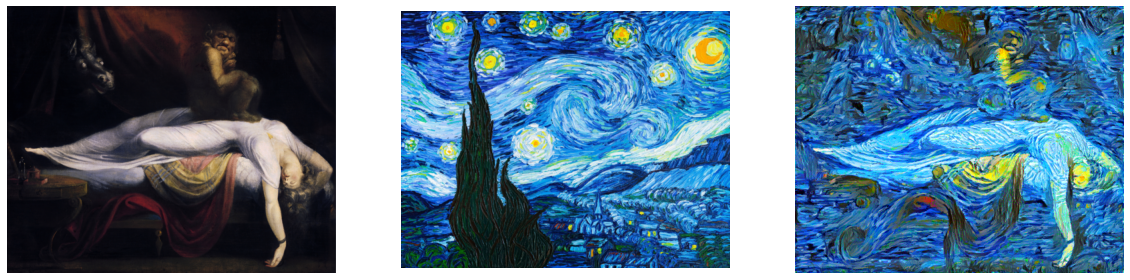

In [48]:
# plotting the final result
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [52]:
# to get the video of the captured frames during the process
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('starry_nightmare.mp4', cv2.VideoWriter_fourcc(*'XVID'), 15, (frame_width, frame_height))

for i in range(0, 300):
    img = image_array[i]
    img = img*255
    img = np.array(img, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)

vid.release()